## Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
from utils.plot_util import *
import socket
import os
from pathlib import Path

In [2]:
import tensorflow as tf

# set up gpu to make sure one gpu can work for multiple scripts at the same time
os.environ["CUDA_VISIBLE_DEVICES"]="1" # use the second gpu
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [3]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/V27/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\V27\\V27-100bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-200bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-30bar_LEM1.h5']

file: V27-200bar_LEM1

ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>

Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>

Points:
(431930,)

shift_opts_freqs_all:
(121, 431930)



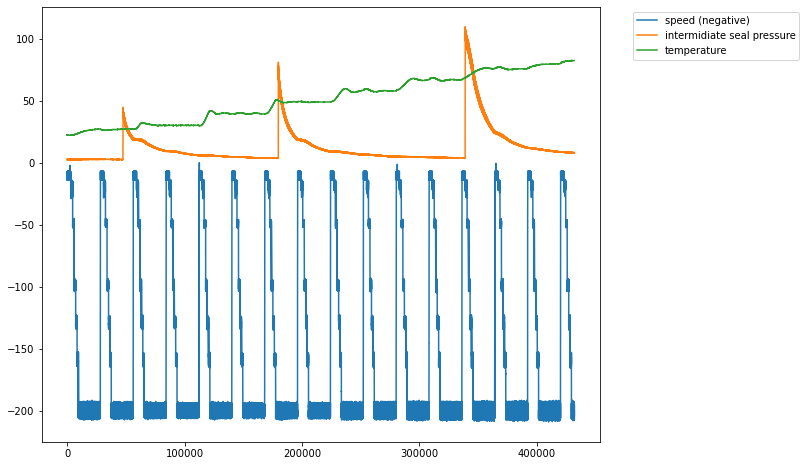

In [4]:
num = 1  # TODO
file = file_list_LEM1[num]
filename = file.split(os.sep)[-1][:-3]
pklName = DIR + '/data/V27/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 
h51 = h5py.File(file, "r")
print("file:",filename)
print("\nATTR:")
print(h51.attrs.keys())
print("\nKeys:")
print(h51.keys())
print("\nPoints:")
print(h51['t'].shape)
print("\nshift_opts_freqs_all:")
print(shift_opts_freqs_all.shape)
print()

#     # print look up dictionary
#     json_object = json.loads(h51.attrs["name_lookup"])
#     json_formatted_str = json.dumps(json_object, indent=2)
#     print("\nLOOKUP:")
#     print(json_formatted_str)

# plot of speed, isp and temperature
fidx = 20
%matplotlib inline
plt.figure(figsize=(10,8))
plt.plot(h51['spd1'],label='speed (negative)')
plt.plot(h51['ip1k1'],label='intermidiate seal pressure')
plt.plot(h51['k1t'],label='temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


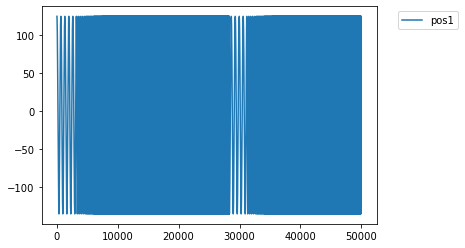

In [5]:
# GT = ['pos1','ip1k1','k1t']
GT = ['pos1']
for gt in GT:
    plt.plot(h51[gt][:50000], label = gt)
plt.legend(bbox_to_anchor=(1.05, 1))

In [6]:
# lsa
low = np.where(h51['spd1'][:]>-40)[0]
pos_low = h51['pos1'][low]
low_sep = np.where(np.diff(low)>3000)[0] # check if 3000 fit for all datasets
pos_low_sep = np.split(pos_low,low_sep+1)
Ls = np.append(low[low_sep],low[-1])
print("timestamps of Ls:")
print (Ls)

Fs = np.append(low[0],low[low_sep+1])
print("timestamps of Fs:")
print (Fs)

print("Durations of lsa:\n",Ls-Fs)

timestamps of Ls:
[  4743  32732  60721  88710 116696 144683 172674 200664 228651 256639
 284625 312612 340597 368587 396572 424559]
timestamps of Fs:
[     0  28336  56326  84315 112303 140291 168277 196268 224257 252245
 280233 308218 336205 364191 392181 420166]
Durations of lsa:
 [4743 4396 4395 4395 4393 4392 4397 4396 4394 4394 4392 4394 4392 4396
 4391 4393]


In [7]:
# end stroke

#  positions bigger or smaller than 100 or 10 mm
p100 = np.where(h51['pos1'][:]>100)[0]
p10 = np.where(h51['pos1'][:]>10)[0]
n100 = np.where(h51['pos1'][:]<-100)[0]
n10 = np.where(h51['pos1'][:]<-10)[0]

#  positions within in or outside absolute value 100 or 10 mm
pos_in_100 = np.array(list(set(np.arange(h51['pos1'].shape[0]))-(set(p100)|set(n100))))
pos_out_100 =  np.sort(np.concatenate((p100,n100)))
pos_in_10 = np.array(list(set(np.arange(h51['pos1'].shape[0]))-(set(p10)|set(n10))))
pos_out_10 =  np.sort(np.concatenate((p10,n10)))

In [8]:
# set up model saving folder
if num == 0:
    SAVED_IN = DIR + "/models/V27/100bar/"
if num == 1:
    SAVED_IN = DIR + "/models/V27/200bar/"
if num == 2:
    SAVED_IN = DIR + "/models/V27/30bar/"
    
SAVED_IN = os.path.abspath(SAVED_IN)
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)


In [9]:
N = 100 # ignore first N points
s21 = np.array(h51['S21_P1_LEM1'])
dataset = []
for j in range (121):
    index = np.arange(N,len(h51['t'])) - shift_opts_freqs_all[j,N:].round().astype(int)
    dataset.append(s21[index,j].real)
    dataset.append(s21[index,j].imag)
    
X = np.asarray(dataset).T
Y = np.vstack(
    (
        np.asarray(h51['pos1'][N:]),
        #np.asarray(h51['spd1'][N:]),
        # np.asarray(h51['ip1k1'][N:]),
        # np.asarray(h51['k1t'][N:])
    )
)
Y = Y.T
print("X:")
print(X.shape)
print("Y:")
print(Y.shape)

X:
(431830, 242)
Y:
(431830, 1)


In [10]:
h51.close()

## Preprocessing

In [11]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

# indices2 = np.arange(X_train.shape[0])
# X_train2, X_val, Y_train2, Y_val, idx_train2, idx_val = train_test_split(X_train, Y_train, indices2, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

print(X_train.shape)
print(X_test.shape)

(345464, 242)
(86366, 242)


In [12]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
# scaler.mean_.shape

In [13]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, Y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, Y_test))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, Y_val))

# BATCH_SIZE = 64

# train_dataset = train_dataset.batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)
# val_dataset = val_dataset.batch(BATCH_SIZE)

## Training

### 64 neurons

In [14]:
NEURONS = 64
MODEL_NAME = f"NN_Micro{NEURONS}_pos"

In [15]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [16]:
def NN_Micro(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, input_shape=(242,), kernel_initializer='normal', activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [17]:
NN = NN_Micro(normalizer)
NN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 64)                15552     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,102
Trainable params: 15,617
Non-trainable params: 485
_________________________________________________________________


In [18]:
%%time
history = NN.fit(
    X_train, Y_train, batch_size = 64,
    validation_data= (X_test,Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')],
    verbose=0, epochs=100)

Wall time: 7min 31s


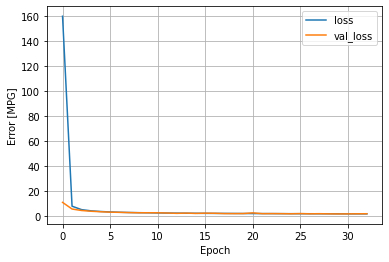

In [19]:
plot_loss(history)

In [20]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\200bar\NN_Micro64_pos\assets


In [21]:
NEURONS = 64
MODEL_NAME = f"NN_Micro{NEURONS}_pos"
NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [22]:
# evaluation on both training and test sets

Y_ = NN.predict(X)
Y_train_ = Y_[idx_train_sort]
Y_test_ =Y_[idx_test_sort]

In [23]:
from sklearn.metrics import mean_squared_error
print ("Average MSE of the prediction on training set: ", mean_squared_error(Y_train_,Y[idx_train_sort]))
print ("Average MSE of the prediction on test set: ", mean_squared_error(Y_test_,Y[idx_test_sort]))

Average MSE of the prediction on training set:  1.9488715158443115
Average MSE of the prediction on test set:  2.043502015570546


In [24]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos1,1.941914,2.043499,1.393526,1.42951


In [25]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
Y_train_lsa_ = Y_[idx_com_train]
Y_test_lsa_ = Y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(Y[idx_com_train] - Y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(Y[idx_com_test] - Y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,1.251957,1.211545


In [26]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - Y_test_
err_in_100 = Y[idx_in_100] - Y_[idx_in_100]
err_out_100 = Y[idx_out_100] - Y_[idx_out_100]
err_in_10 = Y[idx_in_10] - Y_[idx_in_10]
err_out_10 = Y[idx_out_10] - Y_[idx_out_10]
err_p100 = Y[idx_p100] - Y_[idx_p100]
err_n100 = Y[idx_n100] - Y_[idx_n100]
err_p10 = Y[idx_p10] - Y_[idx_p10]
err_n10 = Y[idx_n10] - Y_[idx_n10]

In [27]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,2.043502,1.395778
1,within 100,2.146241,1.422843
2,outside 100,1.914729,1.359414
3,within 10,2.468129,1.506505
4,outside 10,2.021710,1.389493
5,>100,1.656989,1.246627
6,<-100,2.175648,1.462056
7,>10,1.890572,1.336530
8,<-10,2.163209,1.444115


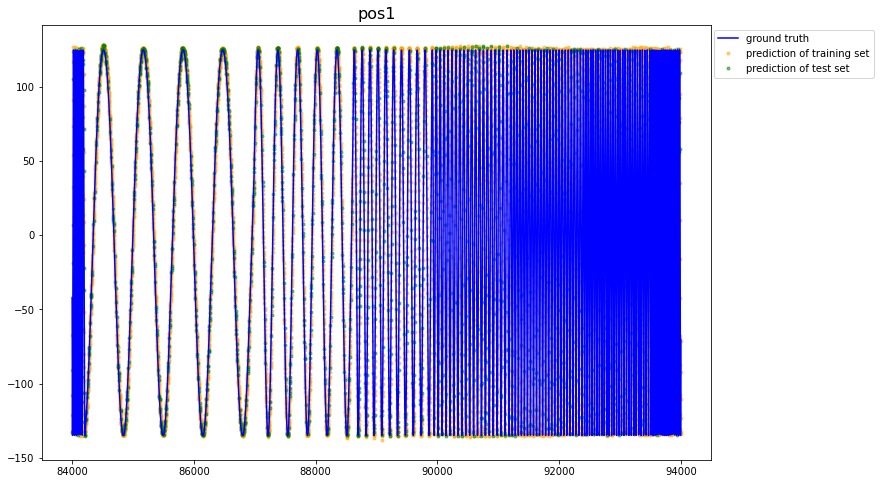

In [28]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(Y,Y_,idx_train_sort,idx_test_sort,GT)

### 32 neurons

In [29]:
NEURONS = 32
MODEL_NAME = f"NN_Micro{NEURONS}_pos"

In [30]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [31]:
def NN_Micro(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(NEURONS, input_shape=(242,), kernel_initializer='normal', activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [32]:
NN = NN_Micro(normalizer)
NN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                7776      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 8,294
Trainable params: 7,809
Non-trainable params: 485
_________________________________________________________________


In [33]:
%%time
history = NN.fit(
    X_train, Y_train, batch_size = 64,
    validation_data= (X_test,Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')],
    verbose=0, epochs=100)

Wall time: 4min 18s


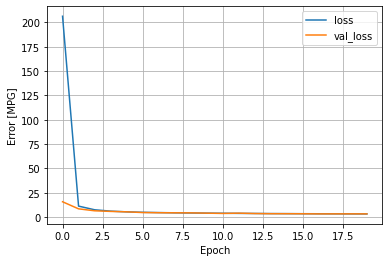

In [34]:
plot_loss(history)

In [35]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\200bar\NN_Micro32_pos\assets


In [36]:
NEURONS = 32
MODEL_NAME = f"NN_Micro{NEURONS}_pos"
NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [37]:
# evaluation on both training and test sets

Y_ = NN.predict(X)
Y_train_ = Y_[idx_train_sort]
Y_test_ =Y_[idx_test_sort]

In [38]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos1,3.163042,3.202754,1.778494,1.789624


In [39]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
Y_train_lsa_ = Y_[idx_com_train]
Y_test_lsa_ = Y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(Y[idx_com_train] - Y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(Y[idx_com_test] - Y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,2.099143,2.037589


In [40]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - Y_test_
err_in_100 = Y[idx_in_100] - Y_[idx_in_100]
err_out_100 = Y[idx_out_100] - Y_[idx_out_100]
err_in_10 = Y[idx_in_10] - Y_[idx_in_10]
err_out_10 = Y[idx_out_10] - Y_[idx_out_10]
err_p100 = Y[idx_p100] - Y_[idx_p100]
err_n100 = Y[idx_n100] - Y_[idx_n100]
err_p10 = Y[idx_p10] - Y_[idx_p10]
err_n10 = Y[idx_n10] - Y_[idx_n10]

In [41]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,3.202756,1.789313
1,within 100,3.304707,1.816944
2,outside 100,3.074971,1.753558
3,within 10,3.667168,1.903865
4,outside 10,3.178922,1.782784
5,>100,2.439678,1.555848
6,<-100,3.718102,1.923453
7,>10,2.881244,1.692237
8,<-10,3.500119,1.868593


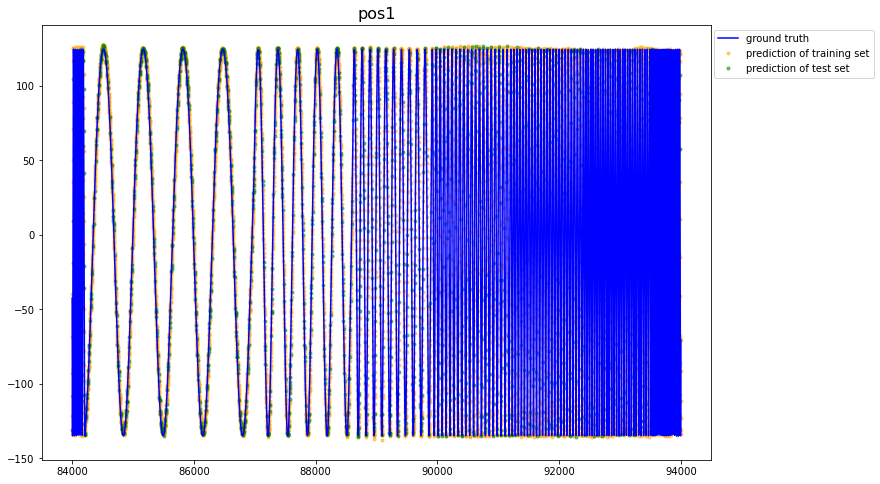

In [42]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(Y,Y_,idx_train_sort,idx_test_sort,GT)

### 16 neurons

In [43]:
NEURONS = 16
MODEL_NAME = f"NN_Micro{NEURONS}_pos"

In [44]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [45]:
def NN_Micro(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(NEURONS, input_shape=(242,), kernel_initializer='normal', activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [46]:
NN = NN_Micro(normalizer)
NN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                3888      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 4,390
Trainable params: 3,905
Non-trainable params: 485
_________________________________________________________________


In [47]:
%%time
history = NN.fit(
    X_train, Y_train, batch_size = 64,
    validation_data= (X_test,Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')],
    verbose=0, epochs=100)

Wall time: 9min 42s


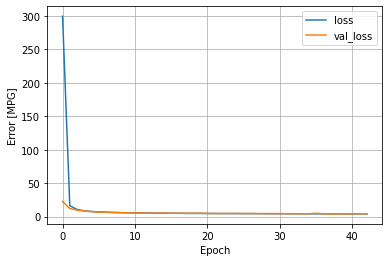

In [48]:
plot_loss(history)

In [49]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\200bar\NN_Micro16_pos\assets


In [50]:
NEURONS = 16
MODEL_NAME = f"NN_Micro{NEURONS}_pos"
NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [51]:
# evaluation on both training and test sets

Y_ = NN.predict(X)
Y_train_ = Y_[idx_train_sort]
Y_test_ =Y_[idx_test_sort]

In [52]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos1,3.90077,4.116628,1.975037,2.028947


In [53]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
Y_train_lsa_ = Y_[idx_com_train]
Y_test_lsa_ = Y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(Y[idx_com_train] - Y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(Y[idx_com_test] - Y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,2.748883,2.716419


In [54]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - Y_test_
err_in_100 = Y[idx_in_100] - Y_[idx_in_100]
err_out_100 = Y[idx_out_100] - Y_[idx_out_100]
err_in_10 = Y[idx_in_10] - Y_[idx_in_10]
err_out_10 = Y[idx_out_10] - Y_[idx_out_10]
err_p100 = Y[idx_p100] - Y_[idx_p100]
err_n100 = Y[idx_n100] - Y_[idx_n100]
err_p10 = Y[idx_p10] - Y_[idx_p10]
err_n10 = Y[idx_n10] - Y_[idx_n10]

In [55]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,4.116628,2.021233
1,within 100,4.272305,2.053885
2,outside 100,3.921502,1.977362
3,within 10,5.243406,2.252081
4,outside 10,4.058801,2.007913
5,>100,3.481202,1.862435
6,<-100,4.367235,2.087261
7,>10,3.828284,1.946458
8,<-10,4.307530,2.071539


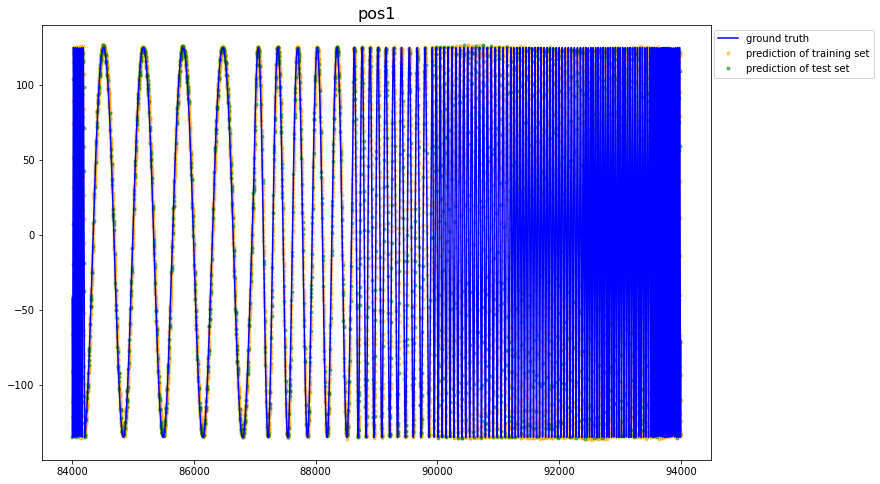

In [56]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(Y,Y_,idx_train_sort,idx_test_sort,GT)

### 8 neurons

In [57]:
NEURONS = 8
MODEL_NAME = f"NN_Micro{NEURONS}_pos"

In [58]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [59]:
def NN_Micro(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(NEURONS, input_shape=(242,), kernel_initializer='normal', activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [60]:
NN = NN_Micro(normalizer)
NN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1944      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,438
Trainable params: 1,953
Non-trainable params: 485
_________________________________________________________________


In [61]:
%%time
history = NN.fit(
    X_train, Y_train, batch_size = 64,
    validation_data= (X_test,Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')],
    verbose=0, epochs=100)

Wall time: 9min 28s


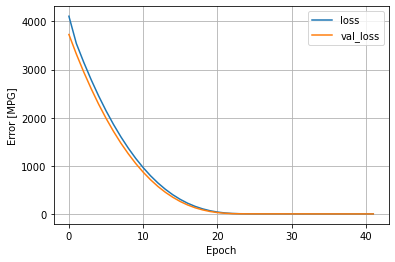

In [62]:
plot_loss(history)

In [63]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\200bar\NN_Micro8_pos\assets


In [64]:
NEURONS = 8
MODEL_NAME = f"NN_Micro{NEURONS}_pos"
NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [65]:
# evaluation on both training and test sets

Y_ = NN.predict(X)
Y_train_ = Y_[idx_train_sort]
Y_test_ =Y_[idx_test_sort]

In [66]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos1,10.14363,10.207197,3.184906,3.19487


In [67]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
Y_train_lsa_ = Y_[idx_com_train]
Y_test_lsa_ = Y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(Y[idx_com_train] - Y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(Y[idx_com_test] - Y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,11.062494,10.889946


In [68]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - Y_test_
err_in_100 = Y[idx_in_100] - Y_[idx_in_100]
err_out_100 = Y[idx_out_100] - Y_[idx_out_100]
err_in_10 = Y[idx_in_10] - Y_[idx_in_10]
err_out_10 = Y[idx_out_10] - Y_[idx_out_10]
err_p100 = Y[idx_p100] - Y_[idx_p100]
err_n100 = Y[idx_n100] - Y_[idx_n100]
err_p10 = Y[idx_p10] - Y_[idx_p10]
err_n10 = Y[idx_n10] - Y_[idx_n10]

In [69]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,10.207201,3.188127
1,within 100,10.761395,3.275984
2,outside 100,9.512575,3.073859
3,within 10,11.715218,3.410508
4,outside 10,10.129808,3.176237
5,>100,6.798464,2.599490
6,<-100,12.260175,3.488259
7,>10,8.551918,2.917557
8,<-10,11.832368,3.433561


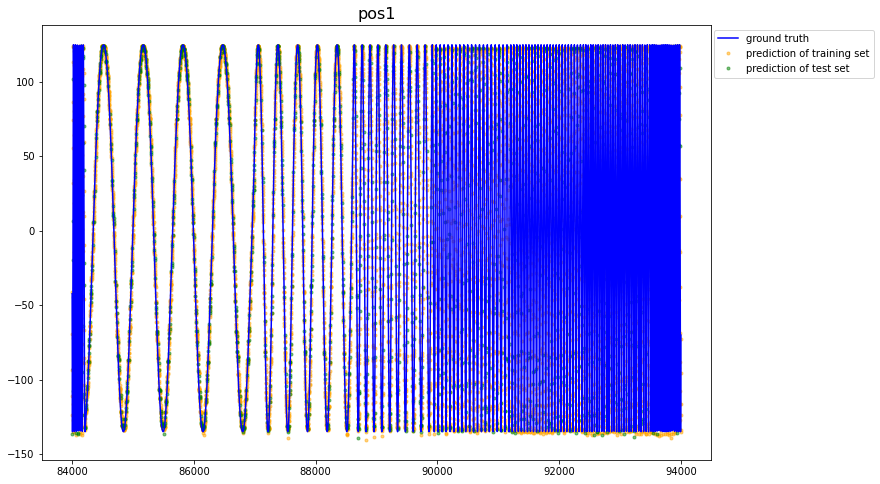

In [70]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(Y,Y_,idx_train_sort,idx_test_sort,GT)

### 4 neurons

In [71]:
NEURONS = 4
MODEL_NAME = f"NN_Micro{NEURONS}_pos"

In [72]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [73]:
def NN_Micro(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(NEURONS, input_shape=(242,), kernel_initializer='normal', activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [74]:
NN = NN_Micro(normalizer)
NN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 972       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 1,462
Trainable params: 977
Non-trainable params: 485
_________________________________________________________________


In [75]:
%%time
history = NN.fit(
    X_train, Y_train, batch_size = 64,
    validation_data= (X_test,Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')],
    verbose=0, epochs=100)

Wall time: 5min 33s


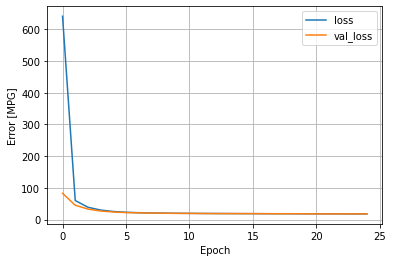

In [76]:
plot_loss(history)

In [77]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\200bar\NN_Micro4_pos\assets


In [78]:
NEURONS = 4
MODEL_NAME = f"NN_Micro{NEURONS}_pos"
NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [79]:
# evaluation on both training and test sets

Y_ = NN.predict(X)
Y_train_ = Y_[idx_train_sort]
Y_test_ =Y_[idx_test_sort]

In [80]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos1,17.970819,17.950562,4.2392,4.23681


In [81]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
Y_train_lsa_ = Y_[idx_com_train]
Y_test_lsa_ = Y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(Y[idx_com_train] - Y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(Y[idx_com_test] - Y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,20.78073,20.45292


In [82]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - Y_test_
err_in_100 = Y[idx_in_100] - Y_[idx_in_100]
err_out_100 = Y[idx_out_100] - Y_[idx_out_100]
err_in_10 = Y[idx_in_10] - Y_[idx_in_10]
err_out_10 = Y[idx_out_10] - Y_[idx_out_10]
err_p100 = Y[idx_p100] - Y_[idx_p100]
err_n100 = Y[idx_n100] - Y_[idx_n100]
err_p10 = Y[idx_p10] - Y_[idx_p10]
err_n10 = Y[idx_n10] - Y_[idx_n10]

In [83]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,17.950571,4.236809
1,within 100,18.011848,4.243144
2,outside 100,17.873765,4.226590
3,within 10,21.851552,4.674411
4,outside 10,17.750369,4.213113
5,>100,15.129082,3.887382
6,<-100,20.652314,4.532373
7,>10,16.222161,4.026252
8,<-10,19.399321,4.403304


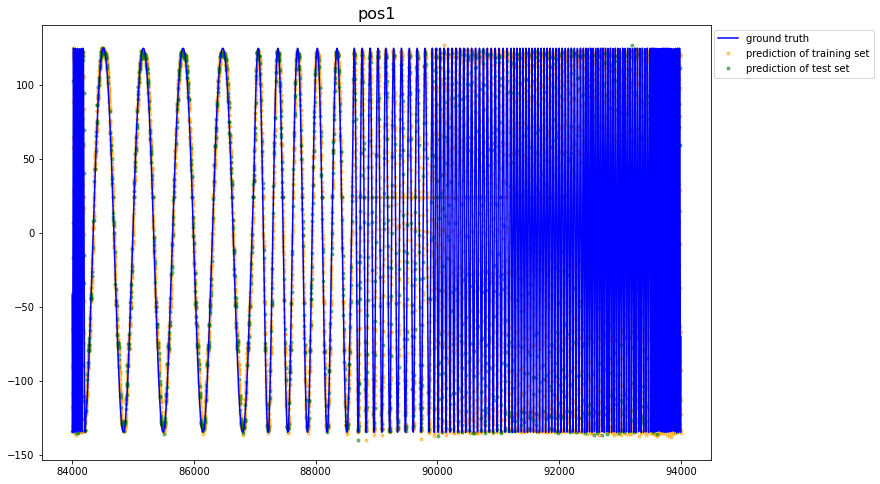

In [84]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(Y,Y_,idx_train_sort,idx_test_sort,GT)